<a href="https://colab.research.google.com/github/Davidportlouis/handwritten_digits_classifier/blob/master/handwritten_digits_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
# necessary libraries
import os
import torch
import time
import numpy as np
from torch import optim, nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

In [44]:
# Test for CUDA

if torch.cuda.is_available():
  print("CUDA is available! Training on GPU ...")
  device = torch.device("cuda")
else:
  print("CUDA is not available. Training on CPU")
  device = torch.device("cpu")

CUDA is available! Training on GPU ...


In [48]:
# Loading data

batch_size = 20
valid_size = 0.2
num_workers = 4

# data augmentation (transforms)
transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize(mean=(0.5), std=(0.5))
])

# downloading MNIST data
train_data = datasets.MNIST(root="./", train=True, transform=transform,
                            download=True)
test_data = datasets.MNIST(root="./", train=False, transform=transform,
                           download=True)

# sampling cross-validation data
train_size = len(train_data)
idx = list(range(train_size))
# randomizing indices
np.random.shuffle(idx)
split = int(np.floor(train_size * valid_size))
train_idx, valid_idx = idx[split:], idx[:split]

# samplers 
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)

# preparing dataloaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size, train_sampler,
                                           num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size, valid_sampler,
                                           num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size, shuffle=True,
                                          num_workers=num_workers)

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


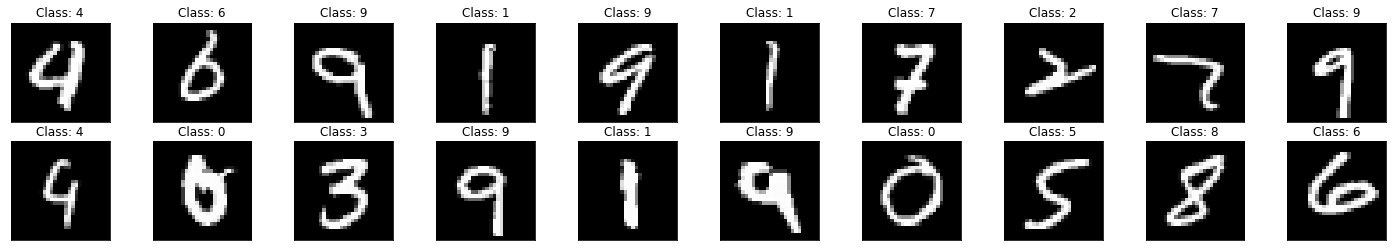

In [50]:
# visualizing data

def plot_batch(batch, labels, preds=None, normalize=False):
  """
  visualize image data in grid space
  """
  fig = plt.figure(figsize=(25, 4))
  for idx in range(len(batch)):
    ax = fig.add_subplot(2, len(batch)/2, idx+1, xticks=[], yticks=[])
    if normalize:
      image = np.array([0.5]) * batch[idx].numpy().squeeze() + np.array([0.5])
    else:
      image = batch[idx]
    ax.imshow(image, cmap="gray")
    if labels is not None and preds is not None:
      ax.set_title(f"Predicted: {preds[idx].item()}",
                   c=("green" if labels[idx] == preds[idx] else "red"))
    elif labels is not None:
      ax.set_title(f"Class: {labels[idx].item()}")

images, labels = next(iter(train_loader))
plot_batch(images, labels, normalize=True)

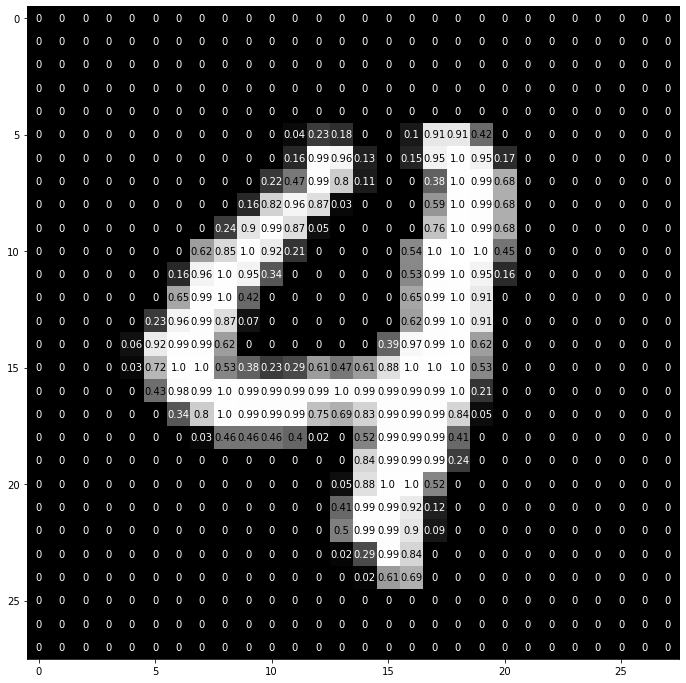

In [59]:
# view image in more detail
img = np.array([0.5]) + images[0].numpy().squeeze() * np.array([0.5]) 

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1,1,1)
ax.imshow(img, cmap="gray")
width, height = img.shape
thresh = img.max() / 2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

In [127]:
# defining network architecture

class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(784, 512)
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 64)
    self.fc4 = nn.Linear(64, 10)
    self.drop = nn.Dropout(p=0.3)

  def forward(self, x):
    # flatten (into row-vector)
    x = x.view(-1, 784)
    x = self.drop(F.relu(self.fc1(x)))
    x = self.drop(F.relu(self.fc2(x)))
    x = self.drop(F.relu(self.fc3(x)))
    x = self.fc4(x)
    return x

model = Net()
model = model.to(device)
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (drop): Dropout(p=0.3, inplace=False)
)


In [135]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [136]:
def train(model, train_loader, valid_loader, criterion, optimizer, epochs, device):
  train_losses, valid_losses = [], []
  last_loss = np.inf

  for e in range(epochs):
    start = time.time()
    train_loss = 0.0
    valid_loss = 0.0

    model.train()
    for features, labels in train_loader:
      features, labels = features.to(device), labels.to(device)
      optimizer.zero_grad()
      logits = model.forward(features)
      loss = criterion(logits, labels)
      loss.backward()
      optimizer.step()
      train_loss += loss.item()

    train_losses.append(train_loss/len(train_loader))

    model.eval()
    for features, labels in valid_loader:
      features, labels = features.to(device), labels.to(device)
      logits = model.forward(features)
      loss = criterion(logits, labels)
      valid_loss += loss.item()

    valid_losses.append(valid_loss/len(valid_loader))

    print(f"Epoch: {e+1}/{epochs} Train loss: {train_loss/len(train_loader):.5f} ",
          f"Valid loss: {valid_loss/len(valid_loader):.5f} Time: {time.time() - start:.3f}s")

    if valid_loss < last_loss:
      print(f"Loss Decreased: {last_loss/len(valid_loader):.5f} -> {valid_loss/len(valid_loader):.5f}")
      print("Saving model")
      torch.save(model.state_dict(), "chkpt.pth") 
      last_loss = valid_loss
  return (train_losses, valid_losses)

train_loss, valid_loss = train(model, train_loader, valid_loader, criterion, optimizer, 30, device)   

Epoch: 1/30 Train loss: 0.21068  Valid loss: 0.12574 Time: 25.761s
Loss Decreased: inf -> 0.12574
Saving model
Epoch: 2/30 Train loss: 0.18062  Valid loss: 0.10206 Time: 25.673s
Loss Decreased: 0.12574 -> 0.10206
Saving model
Epoch: 3/30 Train loss: 0.15799  Valid loss: 0.09044 Time: 25.232s
Loss Decreased: 0.10206 -> 0.09044
Saving model
Epoch: 4/30 Train loss: 0.14270  Valid loss: 0.07897 Time: 25.361s
Loss Decreased: 0.09044 -> 0.07897
Saving model
Epoch: 5/30 Train loss: 0.13053  Valid loss: 0.06926 Time: 25.415s
Loss Decreased: 0.07897 -> 0.06926
Saving model
Epoch: 6/30 Train loss: 0.12161  Valid loss: 0.06762 Time: 25.752s
Loss Decreased: 0.06926 -> 0.06762
Saving model
Epoch: 7/30 Train loss: 0.11297  Valid loss: 0.06002 Time: 24.987s
Loss Decreased: 0.06762 -> 0.06002
Saving model
Epoch: 8/30 Train loss: 0.10598  Valid loss: 0.04940 Time: 25.959s
Loss Decreased: 0.06002 -> 0.04940
Saving model
Epoch: 9/30 Train loss: 0.09623  Valid loss: 0.04657 Time: 25.780s
Loss Decreased: 0

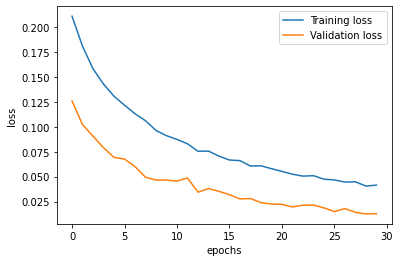

In [137]:
plt.plot(train_loss, label="Training loss")
plt.plot(valid_loss, label="Validation loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

In [138]:
def test(model, test_loader, criterion, device):
  test_loss = 0.0
  class_correct = list(0. for i in range(10))
  class_total = list(0. for i in range(10))

  start = time.time()

  for features, labels in test_loader:
    features, labels = features.to(device), labels.to(device)
    logits = model.forward(features)
    loss = criterion(logits, labels)
    _, preds = torch.max(logits, 1)
    correct = np.squeeze(preds.eq(labels.data.view_as(preds)))
    test_loss += loss.item()
    
    for i in range(batch_size):
      label = labels.data[i]
      class_correct[label] += correct[i].item()
      class_total[label] += 1

  test_loss /= len(train_loader)
  print(f"Test loss: {test_loss:.5f} Time: {time.time() - start:.3f}s")

  for i in range(10):
    if class_total[i] > 0:
      print(f"Test accuracy: {i}: {class_correct[i] * 100 / class_total[i]} ",
            f"({np.sum(class_correct[i])} /{np.sum(class_total[i])})")

  print(f"Test accuracy (Overall): {100 * np.sum(class_correct) / np.sum(class_total)} ",
        f"({np.sum(class_correct)}/{np.sum(class_total)})")

In [139]:
test(model, test_loader, criterion, device)

Test loss: 0.01102 Time: 2.914s
Test accuracy: 0: 98.87755102040816  (969.0 /980.0)
Test accuracy: 1: 99.03083700440529  (1124.0 /1135.0)
Test accuracy: 2: 98.06201550387597  (1012.0 /1032.0)
Test accuracy: 3: 98.7128712871287  (997.0 /1010.0)
Test accuracy: 4: 97.04684317718942  (953.0 /982.0)
Test accuracy: 5: 97.98206278026906  (874.0 /892.0)
Test accuracy: 6: 98.32985386221294  (942.0 /958.0)
Test accuracy: 7: 98.24902723735408  (1010.0 /1028.0)
Test accuracy: 8: 98.4599589322382  (959.0 /974.0)
Test accuracy: 9: 97.42319127849356  (983.0 /1009.0)
Test accuracy (Overall): 98.23  (9823.0/10000.0)


In [140]:
def predict(img, labels, model, device):
  img = img.to(device)
  output = model.forward(img)
  _, preds = torch.max(output, dim=1)
  img = img.to("cpu")
  plot_batch(img, labels, preds.cpu(), normalize=True)

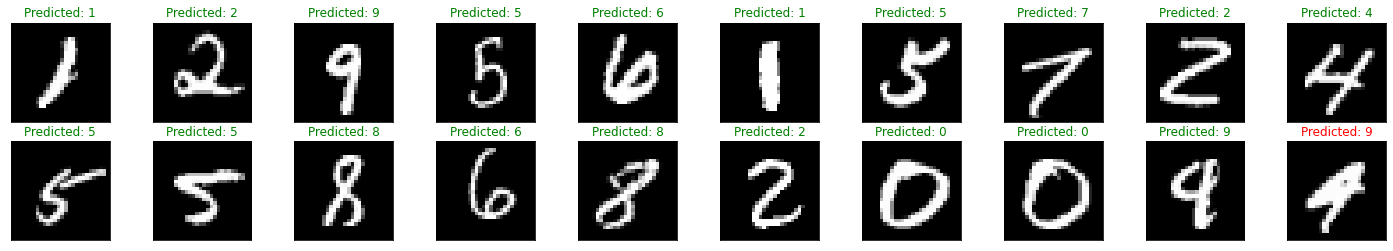

In [141]:
test_images, test_labels = next(iter(test_loader))
predict(test_images, test_labels, model, device)